In [1]:
from model import SugarscapeCg
from agents import Cop, Criminal

from IPython.display import clear_output
from SALib.sample import saltelli
from SALib.analyze import sobol
from mesa.batchrunner import BatchRunner

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Helper functions

In [2]:
def run_model(model):
    model.run_model()

    output = model.datacollector.get_model_vars_dataframe()
    print(output)

    return output

In [3]:
def get_data(df, key):
    all_rows = df[0][key].values

    for i in range(1, len(df)):
        wealths = df[i][key].values
        all_rows = np.vstack([all_rows, wealths])

    all_rows = all_rows.T

    return all_rows

In [4]:
def get_means_cis(data):
    means = []
    cis = []

    for i in range(data.shape[0]):
        means.append(np.mean(data[i]))
        cis.append(1.96*np.std(data[i])/np.sqrt(data.shape[0]))

    return means, cis

In [5]:
def get_average_crime_per_distr(outputs, district_names, burn_in):
    avg_crimes_per_distr_dict = {'Centrum': 0, 'Nieuw-West': 0, 'Noord': 0, 'Oost': 0, 'West': 0, 'Zuid': 0, 'Zuidoost': 0} 
    for i in range(len(outputs)):
        for district in district_names:
            avg_crimes_per_distr_dict[district] += np.mean(outputs[i].iloc[burn_in:][district])
    for district in district_names:
        avg_crimes_per_distr_dict[district] /= len(outputs)
    return dict(sorted(avg_crimes_per_distr_dict.items(), key=lambda item:item[1]))

## Plotting functions

In [6]:
def plot_errorbars(means, cis, y_axis_label):
    plt.errorbar(x=range(len(means)), y=means, yerr=cis, ecolor='red')
    plt.xlabel("Number of steps")
    plt.ylabel(y_axis_label)

In [7]:
def plot_district_crimes(district_means, district_cis, district_names, district_colors):
    for district_index in range(len(district_means)):
        plt.errorbar(x=range(len(district_means[district_index])), y=district_means[district_index], yerr=district_cis[district_index], label=district_names[district_index], color=district_colors[district_index], ecolor=district_colors[district_index])
        plt.xlabel("Number of steps")
        plt.ylabel('Number of crimes')
    plt.legend()

In [8]:
# def plot_district_crimes_bar(district_means, district_cis, district_names, district_colors):
#     plt.bar(np.arange(len(district_means)), height=district_means, yerr=district_cis, color=district_colors, capsize=10)
#     plt.xticks(np.arange(len(district_means)), district_names)
#     # plt.xlabel("Number of steps")
#     plt.ylabel('Number of crimes')

In [9]:
def plot_district_means_bar(avg_crimes_per_distr_dict, district_colors):
    plt.bar(avg_crimes_per_distr_dict.keys(), avg_crimes_per_distr_dict.values(), color=district_colors)
    plt.legend()
    plt.show()
    return

In [10]:
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    indices = s['S' + i]
    errors = s['S' + i + '_conf']
    plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

# Sensitivity Analysis

In [11]:
# We define our variables and bounds
problem = {
    'num_vars': 1,
    'names': ['jail_sentence'],
    'bounds': [[0, 20]]
}

# Set the outputs
model_reporters = {"Crimes": lambda m: m.schedule.get_crimes_commited(), "Criminals in jail": lambda m: m.schedule.get_criminal_count_in_jail()}

# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2#10
max_steps = 30#300
distinct_samples = 10#500

param_values = saltelli.sample(problem, N=distinct_samples, calc_second_order=False)

batch = BatchRunner(SugarscapeCg, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

/opt/homebrew/Caskroom/miniforge/base/envs/python38/lib/python3.8/site-packages/SALib/sample/saltelli.py:94: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (10) is equal to `2^n`.
        
  warnings.warn(msg)


In [12]:
count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['jail_sentence'])
data['Run'], data['Crimes'], data['Criminals in jail'] = None, None, None

# print(data)

for i in range(replicates):
    for vals in param_values: 
        # Change parameters that should be integers
        vals = list(vals)
        vals[0] = int(vals[0])
        # print(vals)
        
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val
        # print(variable_parameters)

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled

        data.iloc[count, 0] = vals  # fills in varied parameter (this has to span more columns when more than 1 parameter is varied)
        data.iloc[count, 1:] = iteration_data  # fills in output data (in this case just 'Run' and 'Crimes')
        count += 1

        clear_output()
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [13]:
print(data)

   jail_sentence Run Crimes Criminals in jail
0              1   0    600                 2
1              9   1    542                 7
2              9   2    430                11
3             11   3    541                 6
4             19   4    554                11
5             19   5    650                11
6             16   6    650                11
7              4   7    650                11
8              4   8    650                11
9              6   9    650                11
10            14  10    650                11
11            14  11    650                11
12             9  12    650                11
13             1  13    650                11
14             1  14    650                11
15            19  15    478                12
16            11  16    554                11
17            11  17    554                11
18            14  18    650                11
19             6  19    650                11
20             6  20    478       

In [14]:
Si_crimes = sobol.analyze(problem, data['Crimes'].values, calc_second_order=False, print_to_console=True)
Si_jail = sobol.analyze(problem, data['Criminals in jail'].values, calc_second_order=False, print_to_console=True)

                     ST   ST_conf
jail_sentence  0.380794  0.394489
                     S1   S1_conf
jail_sentence  0.288203  0.370394
                     ST   ST_conf
jail_sentence  0.541701  0.590793
                     S1   S1_conf
jail_sentence  0.141811  0.322695


{'S1': array([0.28820286]), 'S1_conf': array([0.37039427]), 'ST': array([0.38079359]), 'ST_conf': array([0.3944894])}


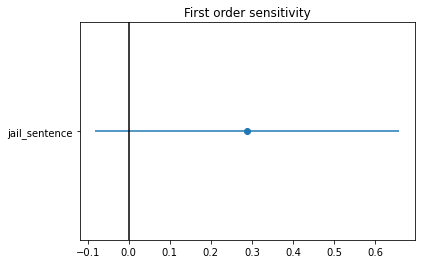

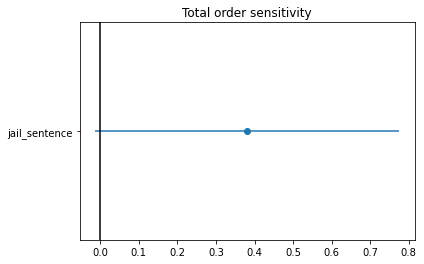

{'S1': array([0.14181118]), 'S1_conf': array([0.32269474]), 'ST': array([0.54170107]), 'ST_conf': array([0.59079346])}


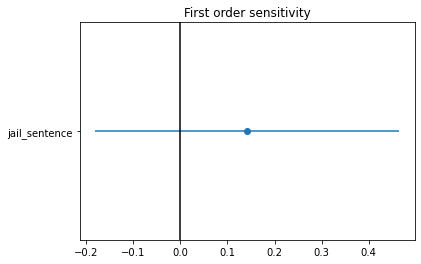

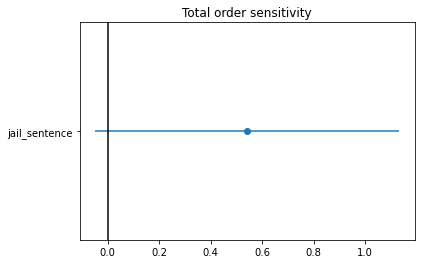

In [15]:
for Si in (Si_crimes, Si_jail):
    print(Si)

    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # # Second order
    # plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    # plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()

# Run model

In [16]:
plt.rcParams["figure.figsize"] = (15,15)
plt.rcParams.update({'font.size': 20})

In [17]:
num_runs = 2
outputs = []

for run in range(num_runs):
    m = SugarscapeCg(criminal_risk_radius=5, cop_catch_radius=1)
    print(f"Search radius for criminal is :{m.criminal_risk_radius}", "\n", f"Catch radius is :{m.cop_catch_radius}")
    output = run_model(m)
    outputs.append(output)

Search radius for criminal is :5 
 Catch radius is :1
     Criminal Wealth  Criminal Count  Criminal in Jail Count  Crimes commited  \
0              682.0              45                       0                0   
1              365.0              45                       0               15   
2              159.0              45                       0               33   
3             -121.0              45                       1               49   
4             -219.0              45                       1               69   
..               ...             ...                     ...              ...   
296          70943.0              45                       2             8242   
297          71213.0              45                       2             8270   
298          71719.0              45                       1             8303   
299          71997.0              45                       1             8332   
300          72353.0              45                   

In [18]:
print(np.mean(outputs[1]["Zuid"]), np.mean(outputs[1]["Centrum"]))

5.016611295681063 2.2259136212624586


## Plots

### Criminal wealths

In [19]:
all_wealths = get_data(outputs, 'Criminal Wealth')

# print(all_wealths[0])
print(all_wealths.shape)

(301, 2)


In [20]:
mean_wealths, cis_wealths = get_means_cis(all_wealths)

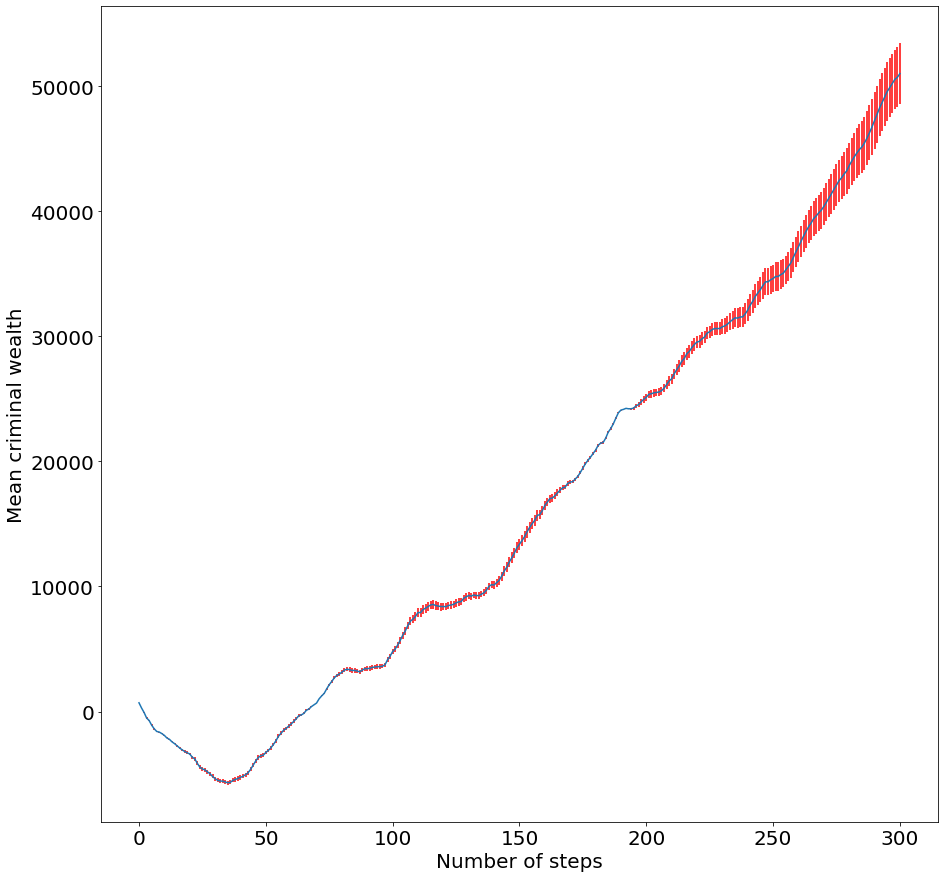

In [21]:
plot_errorbars(mean_wealths, cis_wealths, "Mean criminal wealth")

### Criminals in jail

In [22]:
jail_count = get_data(outputs, 'Criminal in Jail Count')

print(jail_count.shape)

(301, 2)


In [23]:
mean_jail_count, cis_jail_count = get_means_cis(jail_count)

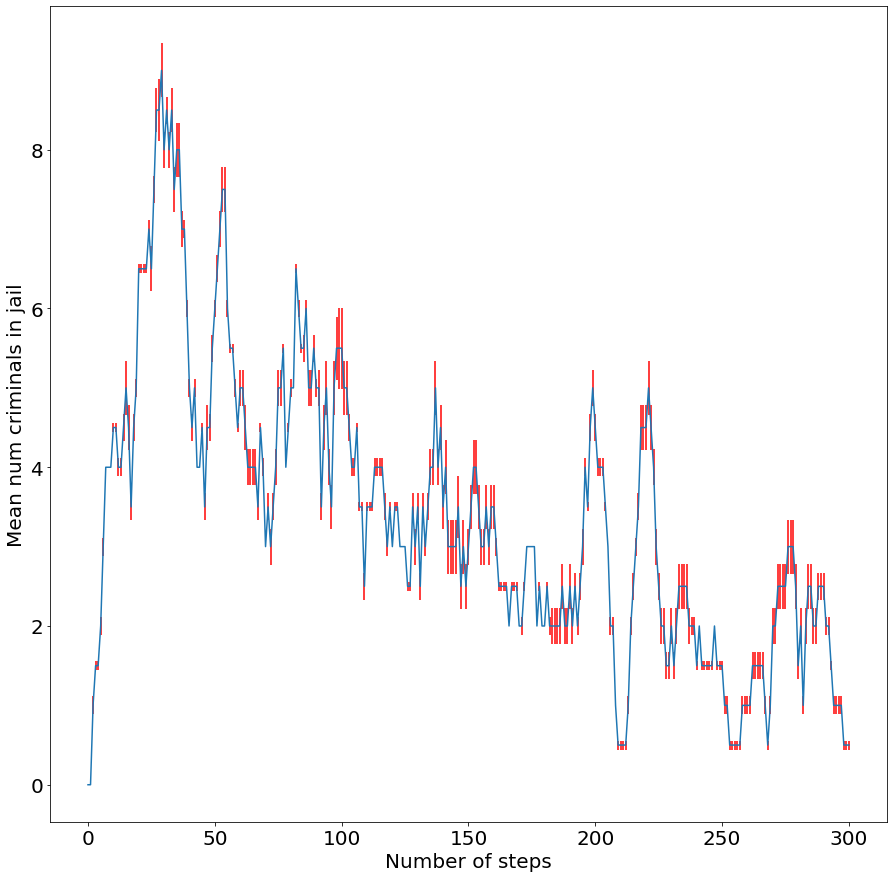

In [24]:
plot_errorbars(mean_jail_count, cis_jail_count, "Mean num criminals in jail")

### Crimes committed

In [25]:
crimes_count = get_data(outputs, 'Crimes commited')

print(crimes_count.shape)

(301, 2)


In [26]:
mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)

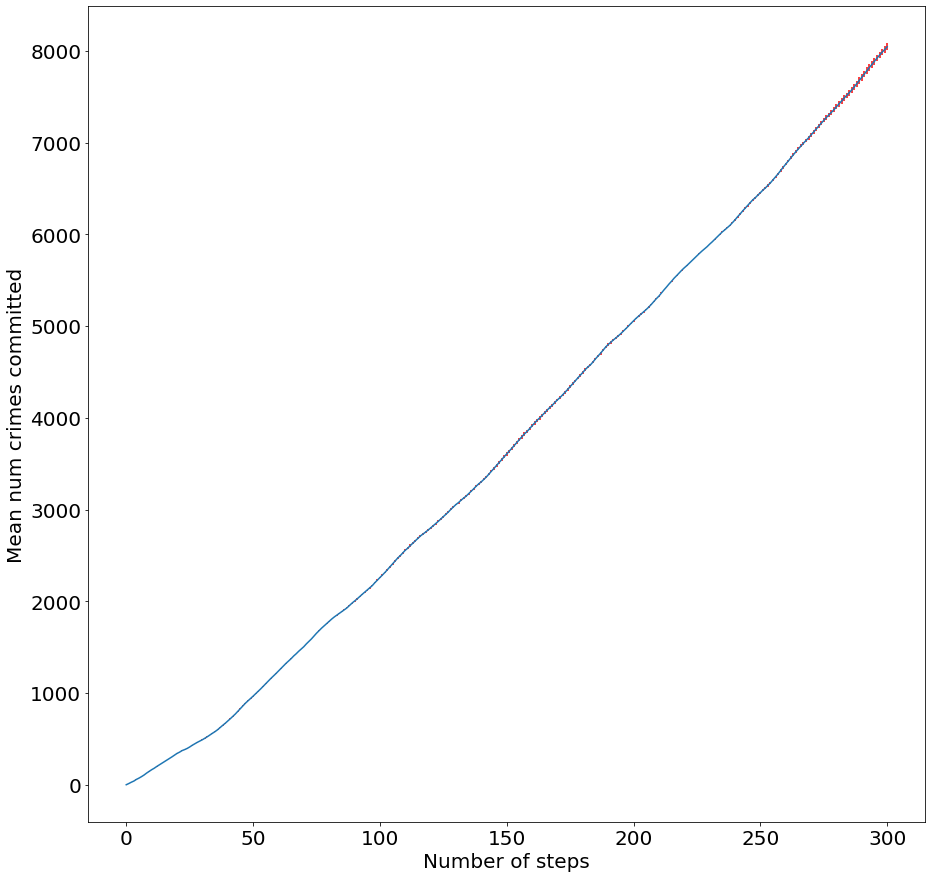

In [27]:
plot_errorbars(mean_crimes_count, cis_crimes_count, "Mean num crimes committed")

### District crimes

No handles with labels found to put in legend.


Zuidoost
West
Noord
Centrum
Oost
Zuid
Nieuw-West


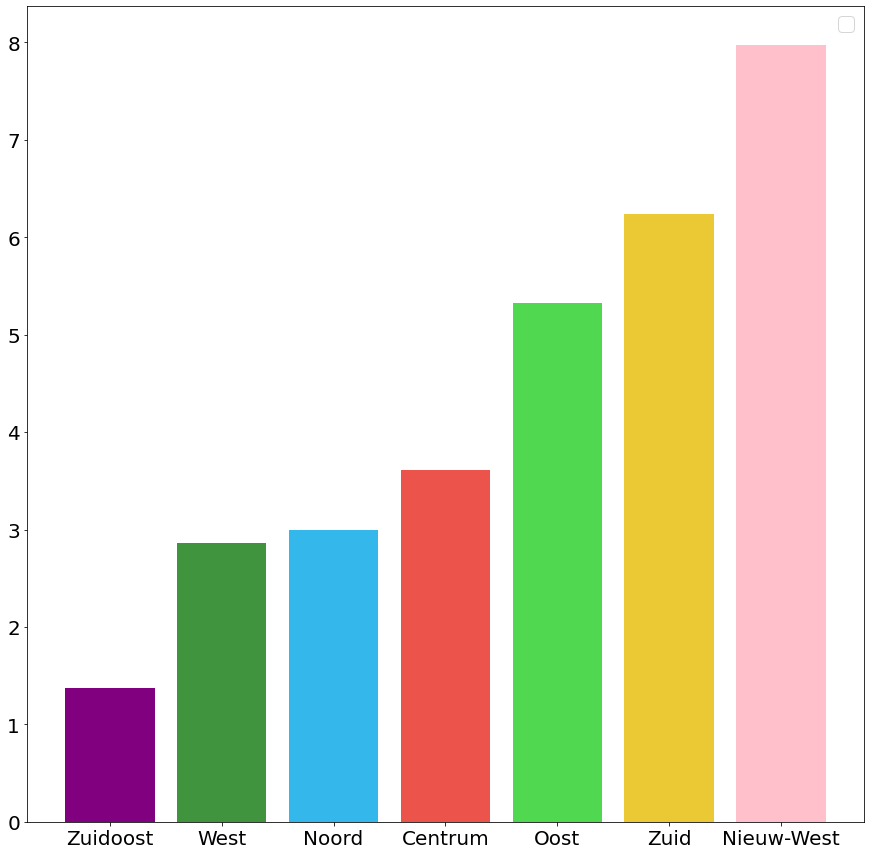

In [28]:
district_names = ['Centrum', 'Noord', 'West', 'Zuid', 'Zuidoost', 'Oost', 'Nieuw-West']
# district_colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
# district_colors = ['#eb534b', '#34b7eb', '#40943d', '#ebc934', '#800080', '#50d950', '#ffc0cb']

districts_dict = [{"Label": "Centrum", "Color": "#eb534b"},{"Label": "Noord", "Color": "#34b7eb"},{"Label": "West", "Color": "#40943d"},{"Label": "Nieuw-West", "Color": "#ffc0cb"},{"Label": "Zuid", "Color": "#ebc934"},{"Label": "Oost", "Color": "#50d950"},{"Label": "Zuidoost", "Color": "#800080"}]

avg_crimes_per_distr_dict = get_average_crime_per_distr(outputs, district_names, 200)

# Sort colors
district_colors = []
for district in avg_crimes_per_distr_dict.keys():
    print(district)
    for dictionary in districts_dict:
        if dictionary['Label'] == district:
            district_colors.append(dictionary['Color'])

plot_district_means_bar(avg_crimes_per_distr_dict, district_colors)

In [29]:
all_district_means = []
all_district_cis = []

for district in district_names:
    crimes_count = get_data(outputs, district)
    mean_crimes_count, cis_crimes_count = get_means_cis(crimes_count)
    all_district_means.append(mean_crimes_count)
    all_district_cis.append(cis_crimes_count)

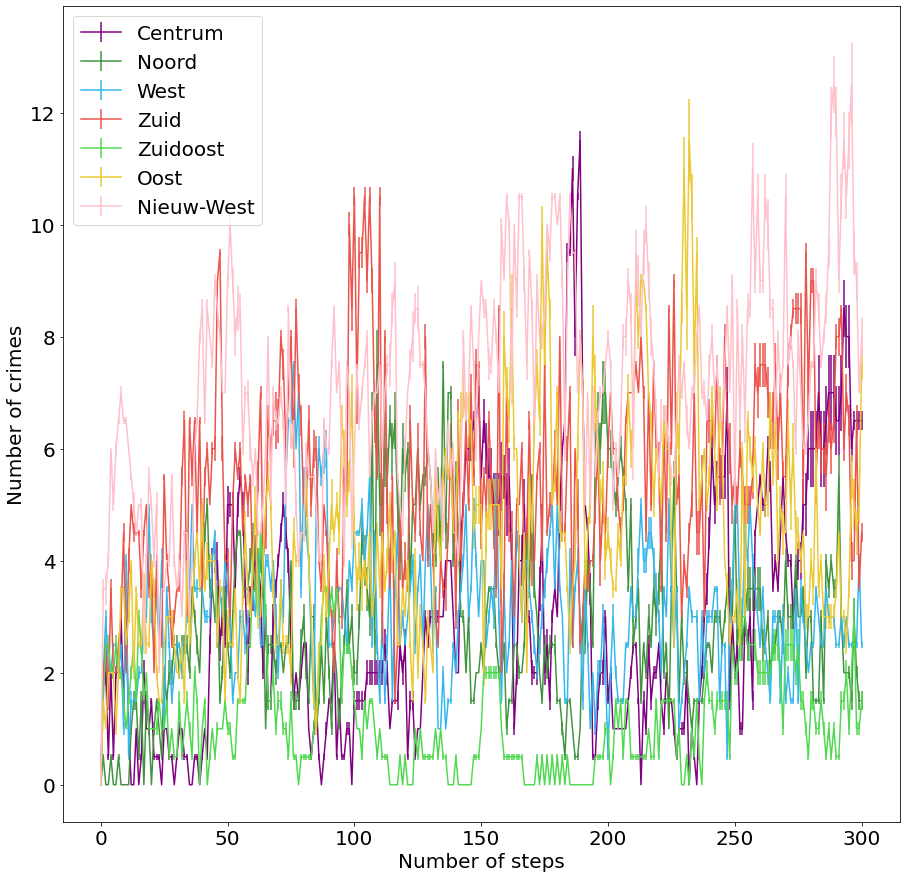

In [30]:
plot_district_crimes(all_district_means, all_district_cis, district_names, district_colors)

In [31]:
# print(len(all_district_means))
# print(len(all_district_means[0]))

# final_district_means = []
# for district in all_district_means:
#     final_district_means.append(district[-1])

# print(final_district_means)

# final_district_cis = []
# for district in all_district_cis:
#     final_district_cis.append(district[-1])

# print(final_district_cis)

In [32]:
# # Sort by size
# sorting = zip(final_district_means, district_names, district_colors)
# final_district_means, district_names, district_colors = zip(*sorted(sorting, key=lambda x : x[0]))

In [33]:
# plot_district_crimes_bar(final_district_means, final_district_cis, district_names, district_colors)